# Kaggle: Santander Customer Transaction Prediction
Dataset: https://www.kaggle.com/competitions/instacart-market-basket-analysis

## Step1 定義問題

- 這個問題是如何產生的？這個問題的預期產出是什麼？預測客戶下一次訂單會買哪些商品
- 它提供了哪些資訊、資料與變數？客戶, 訂單, 產品等
- 會對這個問題可以產生什麼結果？提供更好的購物體驗

### 選擇什麼方法？
- 該問題是監督還是非監督學習？監督式學習
- 該問題的結果是分類還是回歸？二元分類問題
- PS.預測每一項購買過的產品是否會再度購買(reordered欄位, 是:1, 否:0)

## Step2 區分與整理 Train／Test 資料集

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
aisles = pd.read_csv("aisles.csv")
print(aisles.shape)
aisles.head()

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [3]:
departments = pd.read_csv("departments.csv")
print(departments.shape)
departments.head()

(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [4]:
# order_products__prior 所有客戶之前的訂單內容
# reordered 欄位表示客戶有一個包含該產品的先前訂單
order_prior = pd.read_csv("order_products__prior.csv")
print(order_prior.shape)
order_prior.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
order_train = pd.read_csv("order_products__train.csv")
print(order_train.shape)
order_train.head()

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
# eval_set 訂單屬於哪個集合 # order_dow 星期幾
orders = pd.read_csv("orders.csv")
print(orders.shape)
orders.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
products = pd.read_csv("products.csv")
print(products.shape)
products.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


## Step3 進行探索式資料分析(EDA)

### A. 確認資料狀況

In [8]:
# 檢查缺失值
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({"Missing Ratio" : data_na})
    display(missing_data)
na_check(aisles)
na_check(departments)
na_check(order_prior)
na_check(order_train)
na_check(orders)
na_check(products)

,Missing Ratio


,Missing Ratio


,Missing Ratio


,Missing Ratio


,Missing Ratio
days_since_prior_order,6.027594


,Missing Ratio


### 確認資料狀況筆記
- orders 裡的 "days_since_prior_order" 有缺失值
- days_since_prior_order 表示跟上次消費的間隔天數, 若有缺失值是否代表沒有第二次訂單

### B. 樞紐分析與視覺化

In [9]:
# 基本資料確認
print("Numbers of Purchases:{}".format(len(orders))) #共多少筆交易
print("Numbers of Customers:{}".format(orders["user_id"].nunique())) #共多少顧客
print("Distribution of Dataset:")
print(orders["eval_set"].value_counts()) #資料集群大小

Numbers of Purchases:3421083
Numbers of Customers:206209
Distribution of Dataset:
prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64


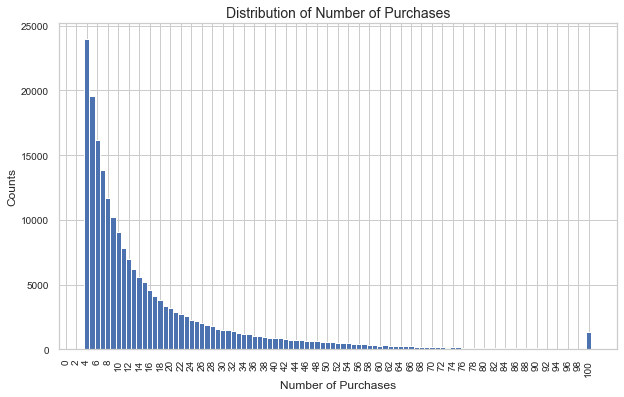

In [10]:
# 確認顧客購買次數的分布
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
counts = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index() # 計算最大值
counts = counts["order_number"].value_counts()
plt.bar(counts.index, counts, color=sns.color_palette()[0], width=1) #購買次數分佈
plt.title("Distribution of Number of Purchases", fontsize=14)
plt.xlabel("Number of Purchases", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.xticks(range(0, 102, 2), fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.show()

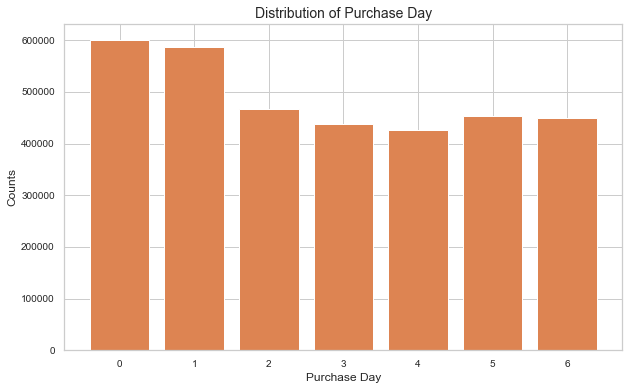

In [11]:
# 顧客的消費習慣-每周採購日分布
plt.figure(figsize=(10,6))
weekdays = orders["order_dow"].value_counts()
plt.bar(weekdays.index, weekdays, color=sns.color_palette()[1])
plt.title("Distribution of Purchase Day", fontsize=14)
plt.xlabel("Purchase Day", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

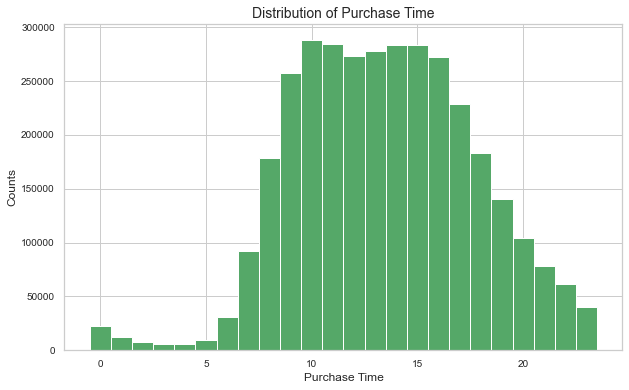

In [12]:
# 顧客的消費習慣-每日消費時間分布
plt.figure(figsize=(10,6))
times = orders["order_hour_of_day"].value_counts()
plt.bar(times.index, times, color=sns.color_palette()[2], width=1)
plt.title("Distribution of Purchase Time", fontsize=14)
plt.xlabel("Purchase Time", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

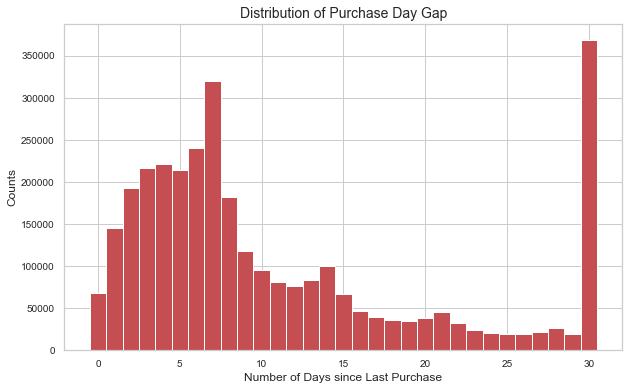

In [13]:
# 消費頻率-跟上次消費的間隔天數分布
plt.figure(figsize=(10,6))
gaps = orders["days_since_prior_order"].value_counts()
plt.bar(gaps.index, gaps, color=sns.color_palette()[3], width=1)
plt.title("Distribution of Purchase Day Gap", fontsize=14)
plt.xlabel("Number of Days since Last Purchase", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [14]:
# 銷售產品排名
product_ranking = order_prior["product_id"].value_counts()
product_ranking.index = [products[products["product_id"]==i]["product_name"].item() for i in product_ranking.index]
product_ranking.head(10)

Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Organic Avocado           176815
Large Lemon               152657
Strawberries              142951
Limes                     140627
Organic Whole Milk        137905
Name: product_id, dtype: int64

In [15]:
# 銷售類別排名
category_ranking = pd.DataFrame(order_prior["product_id"].value_counts().reset_index())
category_ranking.columns = ["product_id", "counts"]
category_ranking = pd.merge(category_ranking, products, on="product_id", how="right")
category_ranking = pd.merge(category_ranking, aisles, on="aisle_id", how="right")
category_ranking.groupby("aisle")["counts"].agg(sum).sort_values(ascending=False).head(10)

aisle
fresh fruits                     3642188.0
fresh vegetables                 3418021.0
packaged vegetables fruits       1765313.0
yogurt                           1452343.0
packaged cheese                   979763.0
milk                              891015.0
water seltzer sparkling water     841533.0
chips pretzels                    722470.0
soy lactosefree                   638253.0
bread                             584834.0
Name: counts, dtype: float64

### 資料視覺化筆記
- **顧客購買次數分布:** 最低購買次數為4筆, 最高為100筆
- **每周採購日分布:** order_dow 並未說明代表星期幾, 因為0和1的購買次數較多, 推測為周末時間  
  → 因此推測0:星期六, 1:星期日, 以此類推, 而消費最多為星期六, 消費最少為星期三
- **每日消費時間分布:** 消費行為大多集中在10點到16點, 這段期間12點左右的消費記錄較少, 推測中午吃飯時間, 較少人進行消費
- **跟上次消費的間隔天數分布:** 出現最多次的為間隔天數7天, 一般人大約會在數天到一個禮拜購買一次民生用品,   
  而間隔天數30天的出現次數更高, 猜測是將間隔天數超過30天的統一歸類在30天
- **銷售排名:** 銷售最多的為水果和蔬菜

## Step4 清理資料
### A. 檢查資料與確認缺失值
1. 是否有遺漏值/缺失值 (Missing value)  
   orders 裡的 "days_since_prior_order" 有缺失值, 這個欄位表示跟上次消費的間隔天數, 若有缺失值推測代表沒有第二次訂單
2. 是否有極值或異常值 (Outlier): NA
3. 資料分布是否符合常態 (Normal Distribution): 從EDA結果來看, 這些欄位不算是常態分布
4. 資料是否需要清洗 (Clean Data): 是, 如下待辦清單

### B. 進行資料加工
待辦清單


In [16]:
# 處理商品
# 1. 將 aisles, department 合併至 products
products = pd.merge(products, aisles, on="aisle_id", how="right")
products = pd.merge(products, departments, on="department_id", how="right")
del aisles, departments

# 2. 將 orders 及 order_prior 做 inner join，合併為 orders_products
order_train = pd.merge(order_train, orders[["order_id", "user_id"]], on="order_id", how="right")
orders_products = pd.merge(orders, order_prior, on="order_id", how="inner")
del order_prior

In [17]:
# 3. 利用 orders_products 建立表格 order_sum，包含每一項商品的：
# 被重複購買的次數 (prod_reorder)
# 被購買的次數 (prod_order)
# 被第一次購買的次數 (prod_1st_orders)
# 被第二次購買的次數 (prod_2nd_orders)
gp = orders_products.groupby("product_id")
order_sum = pd.DataFrame(gp.size(), columns=["prod_orders"])
order_sum["prod_reorder"] = gp["reordered"].agg("sum")
order_sum.reset_index()

temp = orders_products.copy()
temp["prod_order"] = orders_products.groupby(["user_id", "product_id"]).cumcount()
order_sum["prod_1st_orders"] = temp[temp["prod_order"]==0].groupby("product_id")["prod_order"].count()
order_sum["prod_2nd_orders"] = temp[temp["prod_order"]==1].groupby("product_id")["prod_order"].count()
del temp

# 4. 使用(3)欄位來產生以下欄位：
# 被第二度購買機率 (2nd_prob): prod_2nd_orders/prod_1st_orders
# reorder_times: prod_reorder/prod_1st_orders +1
# 被重複購買比例 (reorder_ratio): prod_reorder/prod_orders
order_sum["2nd_prob"] = order_sum["prod_2nd_orders"]/order_sum["prod_1st_orders"]
order_sum["reorder_times"] = [i+1 for i in order_sum["prod_reorder"]/order_sum["prod_1st_orders"]]
order_sum["reorder_ratio"] = order_sum["prod_reorder"]/order_sum["prod_orders"]
order_sum = order_sum.drop(["prod_reorder", "prod_1st_orders", "prod_2nd_orders"], axis=1)
del products
order_sum.head()

,prod_orders,2nd_prob,reorder_times,reorder_ratio
product_id,,,,
1,1852,0.385475,2.586592,0.613391
2,90,0.102564,1.153846,0.133333
3,277,0.486486,3.743243,0.732852
4,329,0.351648,1.807692,0.446809
5,15,0.666667,2.500000,0.600000


In [18]:
# 處理顧客
# 1. 篩選資料集標籤為prior的訂單，建立表格 users_prior，包含每一位顧客的：
# 訂單數量 (user_orders)
# 距離上一次購買天數的總和 (period)
# 距離上一次購買天數的平均 (mean_days_prior)
prior = orders[orders["eval_set"] == "prior"]
gp = prior.groupby("user_id")
users_prior = pd.DataFrame(gp.size(), columns=["user_orders"])
users_prior["period_sum"] = gp["days_since_prior_order"].agg("sum")
users_prior["period_mean"] = gp["days_since_prior_order"].agg("mean")
users_prior = users_prior.reset_index()
del prior

# 2. 建立表格 users，包含每一位使用者的：
# 購買的產品數量總和 (user_total_products)
# 重複購買率 (user_reorder_ratio)
# 購買的產品種類總和 (user_distinct_products)
gp = orders_products.groupby("user_id")
users = pd.DataFrame(gp.size(), columns=["user_total_products"])
order_number_count = gp["order_number"].agg(lambda x: sum(x>1))
reorder_count = gp["reordered"].agg('sum')
users["user_reorder_ratio"] = reorder_count/order_number_count
del order_number_count, reorder_count
users["user_distinct_products"] = gp["product_id"].nunique()
users = users.reset_index()

In [19]:
# 3. 將 users 對 users_prior 做 inner join，並新增欄位：
# 平均單次購買的產品數量 (user_avg_basket) : user_total_products/user_orders
users_prior = pd.merge(users_prior, users, on="user_id", how="inner")
users_prior["user_avg_basket"] = users_prior["user_total_products"]/users_prior["user_orders"]

# 4. 篩選表格 order 中 eval_set 欄位非 prior 的數據，並選取以下欄位：
# user_id, order_id, eval_set, days_since_prior_order 對 users_prior 做 inner join
non_prior = orders[orders["eval_set"] != "prior"][["user_id", "order_id", "eval_set", "days_since_prior_order"]]
users_prior = pd.merge(users_prior, non_prior, on="user_id", how="inner")
del non_prior
users_prior.head()

,user_id,user_orders,period_sum,period_mean,user_total_products,user_reorder_ratio,user_distinct_products,user_avg_basket,order_id,eval_set,days_since_prior_order
0,1,10,176.0,19.555556,59,0.759259,18,5.900000,1187899,train,14.0
1,2,14,198.0,15.230769,195,0.510989,102,13.928571,1492625,train,30.0
2,3,12,133.0,12.090909,88,0.705128,33,7.333333,2774568,test,11.0
3,4,5,55.0,13.750000,18,0.071429,17,3.600000,329954,test,30.0
4,5,4,40.0,13.333333,37,0.538462,23,9.250000,2196797,train,6.0


In [20]:
# 整理Database
# 1. 利用 orders_products建立表格 order_record，包含每一位顧客對每一項商品的：
# 購買該商品的次數 (up_orders)
# 第一次購買該商品的訂單次序 (up_1st_order)
# 最後一次購買該商品的訂單次序 (up_last_order)
# 平均將該商品放入購物車的順序 (up_avg_cart_pos)
gp = orders_products.groupby(["user_id", "product_id"])
order_record = pd.DataFrame(gp.size(), columns=["up_orders"])
order_record["up_1st_order"] = gp["order_number"].agg("min")
order_record["up_last_order"] = gp["order_number"].agg("max")
order_record["up_avg_cart_pos"] = gp["add_to_cart_order"].agg("mean")
order_record = order_record.reset_index()
del orders_products, orders

# 2. 將表格 order_record 及表格 order_sum 做inner join
# 3. 將表格 order_record 及表格 users_prior 做inner join
order_record = pd.merge(order_record, order_sum, on="product_id", how="inner")
order_record = pd.merge(order_record, users_prior, on="user_id", how="inner")

In [21]:
# 4. 在表格 order_record 新增以下欄位，包含每一位顧客對每一項商品的：
# 平均購買該商品的次數 (up_order_rate): up_orders/user_orders
# 連續沒有購買該商品的次數 (up_orders_since_last)
# up_order_rate_since_1st: up_orders/(user_orders — up_1st_order+1)
order_record["up_order_rate"] = order_record["up_orders"]/order_record["user_orders"]
order_record["up_orders_since_last"] = order_record["user_orders"] - order_record["up_last_order"]
order_record["up_order_rate_since_1st"] = order_record["up_orders"]/ \
                                          (order_record["user_orders"]-order_record["up_1st_order"]+1) 

# 5. 將表格 order_record 和 order_train 中的以下欄位做left joint:
# user_id, product_id, reordered
order_record = pd.merge(order_record, order_train[["user_id", "product_id", "reordered"]], 
                        on=["user_id", "product_id"], how="left")
del order_train, order_sum, users_prior
order_record.head()

,user_id,product_id,up_orders,up_1st_order,up_last_order,up_avg_cart_pos,prod_orders,2nd_prob,reorder_times,reorder_ratio,...,user_reorder_ratio,user_distinct_products,user_avg_basket,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last,up_order_rate_since_1st,reordered
0,1,196,10,1,10,1.400000,35791,0.582500,4.473875,0.776480,...,0.759259,18,5.9,1187899,train,14.0,1.0,0,1.000000,1.0
1,1,10258,9,2,10,3.333333,1946,0.552962,3.493716,0.713772,...,0.759259,18,5.9,1187899,train,14.0,0.9,0,1.000000,1.0
2,1,10326,1,5,5,5.000000,5526,0.521581,2.873635,0.652009,...,0.759259,18,5.9,1187899,train,14.0,0.1,5,0.166667,NaN
3,1,12427,10,1,10,3.300000,6476,0.529482,3.857058,0.740735,...,0.759259,18,5.9,1187899,train,14.0,1.0,0,1.000000,NaN
4,1,13032,3,2,10,6.333333,3751,0.479782,2.916796,0.657158,...,0.759259,18,5.9,1187899,train,14.0,0.3,0,0.333333,1.0


## Step5 模型建置與預測

### A. 特徵預處理 (Preprocessing)

In [22]:
order_record.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13307953 entries, 0 to 13307952
Data columns (total 24 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   user_id                  int64  
 1   product_id               int64  
 2   up_orders                int64  
 3   up_1st_order             int64  
 4   up_last_order            int64  
 5   up_avg_cart_pos          float64
 6   prod_orders              int64  
 7   2nd_prob                 float64
 8   reorder_times            float64
 9   reorder_ratio            float64
 10  user_orders              int64  
 11  period_sum               float64
 12  period_mean              float64
 13  user_total_products      int64  
 14  user_reorder_ratio       float64
 15  user_distinct_products   int64  
 16  user_avg_basket          float64
 17  order_id                 int64  
 18  eval_set                 object 
 19  days_since_prior_order   float64
 20  up_order_rate            float64
 21  up_ord

In [23]:
order_record.describe()

,user_id,product_id,up_orders,up_1st_order,up_last_order,up_avg_cart_pos,prod_orders,2nd_prob,reorder_times,reorder_ratio,...,user_total_products,user_reorder_ratio,user_distinct_products,user_avg_basket,order_id,days_since_prior_order,up_order_rate,up_orders_since_last,up_order_rate_since_1st,reordered
count,1.330795e+07,1.330795e+07,1.330795e+07,1.330795e+07,1.330795e+07,1.330795e+07,1.330795e+07,1.327802e+07,1.330795e+07,1.330795e+07,...,1.330795e+07,1.330795e+07,1.330795e+07,1.330795e+07,1.330795e+07,1.330795e+07,1.330795e+07,1.330795e+07,1.330795e+07,828824.0
mean,1.029987e+05,2.551351e+04,2.437226e+00,1.069173e+01,1.586742e+01,9.217425e+00,2.249905e+04,4.010580e-01,2.437226e+00,5.345431e-01,...,3.107916e+02,5.396860e-01,1.141623e+02,1.270054e+01,1.706505e+06,1.436048e+01,1.542015e-01,9.512767e+00,2.966876e-01,1.0
std,5.943677e+04,1.422429e+04,3.554528e+00,1.347890e+01,1.730285e+01,6.984266e+00,5.587238e+04,1.307860e-01,9.323561e-01,1.624641e-01,...,3.097927e+02,1.918061e-01,7.833439e+01,6.299273e+00,9.900382e+05,1.037458e+01,1.645884e-01,1.341695e+01,2.819098e-01,0.0
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.950495e-03,1.000000e+00,0.000000e+00,...,3.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.010101e-02,0.000000e+00,1.010101e-02,1.0
25%,5.157900e+04,1.329200e+04,1.000000e+00,2.000000e+00,4.000000e+00,4.000000e+00,1.050000e+03,3.190361e-01,1.791667e+00,4.418605e-01,...,9.600000e+01,4.075829e-01,5.600000e+01,8.250000e+00,8.469230e+05,6.000000e+00,4.545455e-02,1.000000e+00,8.888889e-02,1.0
50%,1.027130e+05,2.564000e+04,1.000000e+00,6.000000e+00,9.000000e+00,7.500000e+00,4.306000e+03,4.079861e-01,2.271090e+00,5.596828e-01,...,2.050000e+02,5.600000e-01,9.600000e+01,1.153333e+01,1.699900e+06,1.100000e+01,9.615385e-02,4.000000e+00,2.000000e-01,1.0
75%,1.544500e+05,3.815700e+04,2.000000e+00,1.300000e+01,2.100000e+01,1.200000e+01,1.643900e+04,4.920635e-01,2.871918e+00,6.518007e-01,...,4.200000e+02,6.888889e-01,1.540000e+02,1.592857e+01,2.566503e+06,2.600000e+01,2.000000e-01,1.200000e+01,4.000000e-01,1.0
max,2.062090e+05,4.968800e+04,9.900000e+01,9.900000e+01,9.900000e+01,1.450000e+02,4.725650e+05,1.000000e+00,1.700000e+01,9.411765e-01,...,3.725000e+03,1.000000e+00,7.260000e+02,7.025000e+01,3.421070e+06,3.000000e+01,1.000000e+00,9.800000e+01,1.000000e+00,1.0


In [24]:
# 檢查缺失值
na_check(order_record)

,Missing Ratio
reordered,93.771965
2nd_prob,0.224903


### B. 準備訓練／測試集 (Train / Test Split)

In [25]:
# 1. 先將特徵矩陣（自變數）與應變數區分出來
order_record = order_record.fillna(0)
train_X = order_record[order_record["eval_set"]=="train"].drop(["user_id","product_id",
                                                              "order_id","eval_set","reordered"],axis=1)
train_Y = order_record[order_record["eval_set"]=="train"]["reordered"].astype(int)
test = order_record[order_record["eval_set"]=="test"].drop(["user_id","eval_set","reordered"],axis=1)
test_X = test.drop(["product_id","order_id"],axis=1)
del order_record

In [26]:
# 2. 拆分訓練和驗證集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.3, random_state=10)

### C. 訓練與評估模型 (Model Training)
使用default參數、設定random_state=10做預測

In [27]:
from xgboost.sklearn import XGBClassifier 
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

### 1. XGBoost

In [28]:
# 1. 使用XGBoost default參數預測
xgb = XGBClassifier(random_state=10,objective="binary:logistic")
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
print("XGBoost Accuracy: %.3f" % accuracy_score(y_test, y_pred))
print("XGBoost F1-score: %.3f" % f1_score(y_test, y_pred))

XGBoost Accuracy: 0.910
XGBoost F1-score: 0.294


In [29]:
xgb_pred = xgb.predict(test_X)
xgb_pred = [1 if x > 0.5 else 0 for x in xgb_pred]
test["reordered"] = xgb_pred

submission = test[test["reordered"]==1]
submission = submission.groupby("order_id")["product_id"].agg(lambda l: ' '.join([str(i) for i in l]))
submission = submission.to_frame("products").reset_index()

missing_orders = pd.DataFrame(set(test["order_id"]) - set(submission["order_id"]), columns=["order_id"])
missing_orders["products"] = "None"
submission = submission.append(missing_orders)
submission = submission.sort_values("order_id")
submission.columns = ["order_id", "products"]
submission.to_csv("submission_xgb.csv", index=False)

### 2. LightGBM

In [30]:
# 1. 使用LightGBM default參數預測
lgbm = LGBMClassifier(random_state=10, objective="binary")
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
print("LightGBM Accuracy: %.3f" % accuracy_score(y_test, y_pred))
print("LightGBM F1-score: %.3f" % f1_score(y_test, y_pred))

LightGBM Accuracy: 0.910
LightGBM F1-score: 0.290


In [31]:
lgbm_pred = lgbm.predict(test_X)
lgbm_pred = [1 if x > 0.5 else 0 for x in lgbm_pred]
test["reordered"] = lgbm_pred

submission = test[test["reordered"]==1]
submission = submission.groupby("order_id")["product_id"].agg(lambda l: ' '.join([str(i) for i in l]))
submission = submission.to_frame("products").reset_index()

missing_orders = pd.DataFrame(set(test["order_id"]) - set(submission["order_id"]), columns=["order_id"])
missing_orders["products"] = "None"
submission = submission.append(missing_orders)
submission = submission.sort_values("order_id")
submission.columns = ["order_id", "products"]
submission.to_csv("submission_lgbm.csv", index=False)

### 2. LightGBM + 調整參數

In [34]:
# 調整參數-n_estimators
param_grid = {"n_estimators":list(range(20, 200, 40))}

lgbm_gscv = GridSearchCV(lgbm, param_grid, scoring="f1", verbose=3)
search_result = lgbm_gscv.fit(X_train, y_train)
print("Best Score: %.3f using %s" % (search_result.best_score_, search_result.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...................n_estimators=20;, score=0.210 total time=  17.0s
[CV 2/5] END ...................n_estimators=20;, score=0.215 total time=  10.9s
[CV 3/5] END ...................n_estimators=20;, score=0.207 total time=   9.8s
[CV 4/5] END ...................n_estimators=20;, score=0.207 total time=   9.2s
[CV 5/5] END ...................n_estimators=20;, score=0.214 total time=  10.1s
[CV 1/5] END ...................n_estimators=60;, score=0.286 total time=  24.4s
[CV 2/5] END ...................n_estimators=60;, score=0.287 total time=  28.4s
[CV 3/5] END ...................n_estimators=60;, score=0.286 total time=  30.4s
[CV 4/5] END ...................n_estimators=60;, score=0.285 total time=  32.2s
[CV 5/5] END ...................n_estimators=60;, score=0.287 total time=  36.9s
[CV 1/5] END ..................n_estimators=100;, score=0.290 total time=  54.8s
[CV 2/5] END ..................n_estimators=100;,

In [36]:
# 調整參數-max_depth
param_grid = {"max_depth":list(range(2,12,2))}

lgbm_gscv = GridSearchCV(lgbm, param_grid, scoring="f1", verbose=3)
search_result = lgbm_gscv.fit(X_train, y_train)
print("Best Score: %.3f using %s" % (search_result.best_score_, search_result.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .......................max_depth=2;, score=0.261 total time=  12.9s
[CV 2/5] END .......................max_depth=2;, score=0.268 total time=  16.3s
[CV 3/5] END .......................max_depth=2;, score=0.264 total time=  18.8s
[CV 4/5] END .......................max_depth=2;, score=0.263 total time=  18.6s
[CV 5/5] END .......................max_depth=2;, score=0.268 total time=  18.5s
[CV 1/5] END .......................max_depth=4;, score=0.277 total time=  25.3s
[CV 2/5] END .......................max_depth=4;, score=0.278 total time=  25.8s
[CV 3/5] END .......................max_depth=4;, score=0.278 total time=  25.6s
[CV 4/5] END .......................max_depth=4;, score=0.278 total time=  26.3s
[CV 5/5] END .......................max_depth=4;, score=0.280 total time=  25.3s
[CV 1/5] END .......................max_depth=6;, score=0.289 total time=  32.9s
[CV 2/5] END .......................max_depth=6;,

In [37]:
# 調整參數-subsample # Subsample ratio of the training instance
param_grid = {"subsample":list(np.arange(0.2, 1.2, 0.2))}

lgbm_gscv = GridSearchCV(lgbm, param_grid, scoring="f1", verbose=3)
search_result = lgbm_gscv.fit(X_train, y_train)
print("Best Score: %.3f using %s" % (search_result.best_score_, search_result.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .....................subsample=0.2;, score=0.290 total time=  27.6s
[CV 2/5] END .....................subsample=0.2;, score=0.290 total time=  36.2s
[CV 3/5] END .....................subsample=0.2;, score=0.289 total time=  34.7s
[CV 4/5] END .....................subsample=0.2;, score=0.289 total time=  33.7s
[CV 5/5] END .....................subsample=0.2;, score=0.291 total time=  35.6s
[CV 1/5] END .....................subsample=0.4;, score=0.290 total time=  37.6s
[CV 2/5] END .....................subsample=0.4;, score=0.290 total time=  34.9s
[CV 3/5] END .....................subsample=0.4;, score=0.289 total time=  35.6s
[CV 4/5] END .....................subsample=0.4;, score=0.289 total time=  36.1s
[CV 5/5] END .....................subsample=0.4;, score=0.291 total time=  34.8s
[CV 1/5] END ......subsample=0.6000000000000001;, score=0.290 total time=  35.5s
[CV 2/5] END ......subsample=0.6000000000000001;,

In [40]:
# 調整參數-colsample_bytree # Subsample ratio of columns when constructing each tree
param_grid = {"colsample_bytree":list(np.arange(0.2, 1.2, 0.2))}

lgbm_gscv = GridSearchCV(lgbm, param_grid, scoring="f1", verbose=3)
search_result = lgbm_gscv.fit(X_train, y_train)
print("Best Score: %.3f using %s" % (search_result.best_score_, search_result.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ..............colsample_bytree=0.2;, score=0.268 total time=  30.1s
[CV 2/5] END ..............colsample_bytree=0.2;, score=0.268 total time=  26.7s
[CV 3/5] END ..............colsample_bytree=0.2;, score=0.267 total time=  28.3s
[CV 4/5] END ..............colsample_bytree=0.2;, score=0.267 total time=  25.1s
[CV 5/5] END ..............colsample_bytree=0.2;, score=0.269 total time=  24.1s
[CV 1/5] END ..............colsample_bytree=0.4;, score=0.282 total time=  26.5s
[CV 2/5] END ..............colsample_bytree=0.4;, score=0.282 total time=  29.3s
[CV 3/5] END ..............colsample_bytree=0.4;, score=0.281 total time=  25.7s
[CV 4/5] END ..............colsample_bytree=0.4;, score=0.281 total time=  27.4s
[CV 5/5] END ..............colsample_bytree=0.4;, score=0.282 total time=  25.2s
[CV 1/5] END colsample_bytree=0.6000000000000001;, score=0.286 total time=  30.0s
[CV 2/5] END colsample_bytree=0.6000000000000001

In [45]:
# 調整參數-learning_rate # Boosting learning rate
param_grid = {"learning_rate":[10 ** (i) for i in range(-3, 2, 1)]}

lgbm_gscv = GridSearchCV(lgbm, param_grid, scoring="f1", verbose=3)
search_result = lgbm_gscv.fit(X_train, y_train)
print("Best Score: %.3f using %s" % (search_result.best_score_, search_result.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...............learning_rate=0.001;, score=0.000 total time=  36.4s
[CV 2/5] END ...............learning_rate=0.001;, score=0.000 total time=  43.4s
[CV 3/5] END ...............learning_rate=0.001;, score=0.000 total time=  38.7s
[CV 4/5] END ...............learning_rate=0.001;, score=0.000 total time=  38.7s
[CV 5/5] END ...............learning_rate=0.001;, score=0.000 total time=  37.0s
[CV 1/5] END ................learning_rate=0.01;, score=0.028 total time=  38.5s
[CV 2/5] END ................learning_rate=0.01;, score=0.030 total time=  37.8s
[CV 3/5] END ................learning_rate=0.01;, score=0.029 total time=  38.4s
[CV 4/5] END ................learning_rate=0.01;, score=0.029 total time=  38.6s
[CV 5/5] END ................learning_rate=0.01;, score=0.031 total time=  39.3s
[CV 1/5] END .................learning_rate=0.1;, score=0.290 total time=  34.7s
[CV 2/5] END .................learning_rate=0.1;,

In [46]:
# 調整參數-reg_alpha # L1 regularization
param_grid = {"reg_alpha":[10 ** (i) for i in range(-3, 2, 1)]}

lgbm_gscv = GridSearchCV(lgbm, param_grid, scoring="f1", verbose=3)
search_result = lgbm_gscv.fit(X_train, y_train)
print("Best Score: %.3f using %s" % (search_result.best_score_, search_result.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...................reg_alpha=0.001;, score=0.290 total time=  39.6s
[CV 2/5] END ...................reg_alpha=0.001;, score=0.290 total time=  43.3s
[CV 3/5] END ...................reg_alpha=0.001;, score=0.289 total time=  51.7s
[CV 4/5] END ...................reg_alpha=0.001;, score=0.289 total time= 1.1min
[CV 5/5] END ...................reg_alpha=0.001;, score=0.291 total time= 1.0min
[CV 1/5] END ....................reg_alpha=0.01;, score=0.290 total time= 1.0min
[CV 2/5] END ....................reg_alpha=0.01;, score=0.290 total time= 1.1min
[CV 3/5] END ....................reg_alpha=0.01;, score=0.290 total time= 1.0min
[CV 4/5] END ....................reg_alpha=0.01;, score=0.289 total time=  59.7s
[CV 5/5] END ....................reg_alpha=0.01;, score=0.291 total time=  55.8s
[CV 1/5] END .....................reg_alpha=0.1;, score=0.290 total time=  41.2s
[CV 2/5] END .....................reg_alpha=0.1;,

In [47]:
# 調整參數-reg_lambda # L2 regularization
param_grid = {"reg_lambda":[10 ** (i) for i in range(-3, 2, 1)]}

lgbm_gscv = GridSearchCV(lgbm, param_grid, scoring="f1", verbose=3)
search_result = lgbm_gscv.fit(X_train, y_train)
print("Best Score: %.3f using %s" % (search_result.best_score_, search_result.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ..................reg_lambda=0.001;, score=0.290 total time=  35.1s
[CV 2/5] END ..................reg_lambda=0.001;, score=0.290 total time=  33.9s
[CV 3/5] END ..................reg_lambda=0.001;, score=0.289 total time=  35.2s
[CV 4/5] END ..................reg_lambda=0.001;, score=0.289 total time=  33.8s
[CV 5/5] END ..................reg_lambda=0.001;, score=0.291 total time=  34.6s
[CV 1/5] END ...................reg_lambda=0.01;, score=0.289 total time=  34.9s
[CV 2/5] END ...................reg_lambda=0.01;, score=0.290 total time=  33.6s
[CV 3/5] END ...................reg_lambda=0.01;, score=0.289 total time=  37.0s
[CV 4/5] END ...................reg_lambda=0.01;, score=0.289 total time=  35.1s
[CV 5/5] END ...................reg_lambda=0.01;, score=0.291 total time=  47.1s
[CV 1/5] END ....................reg_lambda=0.1;, score=0.290 total time=  42.4s
[CV 2/5] END ....................reg_lambda=0.1;,

In [48]:
# 使用LightGBM調整參數後
lgbm_tuned = LGBMClassifier(objective="binary",n_estimators=180,max_depth=8,subsample=0.2,
                            colsample_bytree=1.0,learning_rate=0.1,reg_alpha=0.01,reg_lambda=10)
lgbm_tuned.fit(X_train, y_train)
y_pred = lgbm_tuned.predict(X_test)
print("LightGBM Accuracy: %.3f" % accuracy_score(y_test, y_pred))
print("LightGBM F1-score: %.3f" % f1_score(y_test, y_pred))

LightGBM Accuracy: 0.910
LightGBM F1-score: 0.291


In [52]:
lgbm_pred = lgbm_tuned.predict(test_X)
lgbm_pred = [1 if x > 0.5 else 0 for x in lgbm_pred]
test["reordered"] = lgbm_pred

submission = test[test["reordered"]==1]
submission = submission.groupby("order_id")["product_id"].agg(lambda l: ' '.join([str(i) for i in l]))
submission = submission.to_frame("products").reset_index()

missing_orders = pd.DataFrame(set(test["order_id"]) - set(submission["order_id"]), columns=["order_id"])
missing_orders["products"] = "None"
submission = submission.append(missing_orders)
submission = submission.sort_values("order_id")
submission.columns = ["order_id", "products"]
submission.to_csv("submission_lgbm_tuned.csv", index=False)

### 模型預測筆記
- GridSearch計算量很龐大, 以目前的設備, 只能一次調整一個參數
- 若想要繼續讓預測結果優化, 可以尋找釋放記憶體的方式、讓參數間隔變小、更好的隨機種子等